# Sentiment Analysis for Mental Health Detection


### Table of contents
- [1 - Download and Pre-process the data](#1)
- [2 - Build BERT model using Transfer learning](#2)
- [3 - Train model](#3)
- [4 - Evaluation and Visualization of the results](#4)

In [1]:
# !pip install transformers datasets torch torchvision torchaudio
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 9.3 MB/s eta 0:00:00


In [2]:
import kagglehub

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.utils import shuffle
from tqdm import tqdm

import nlpaug.augmenter.word.context_word_embs as aug

<a name='1'></a>
### 1 - Download Data and Pre-processing

In [3]:
# Download latest version of dataset
path = kagglehub.dataset_download("sahasourav17/students-anxiety-and-depression-dataset")
file_path = os.path.join(path, "dataset.xlsx")
df = pd.read_excel(file_path)
df.info()

100%|██████████| 295k/295k [00:00<00:00, 97.9MB/s]

Extracting files...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6982 entries, 0 to 6981
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    6972 non-null   object 
 1   label   6980 non-null   float64
dtypes: float64(1), object(1)
memory usage: 109.2+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6970 entries, 0 to 6969
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    6970 non-null   object 
 1   label   6970 non-null   float64
dtypes: float64(1), object(1)
memory usage: 109.0+ KB


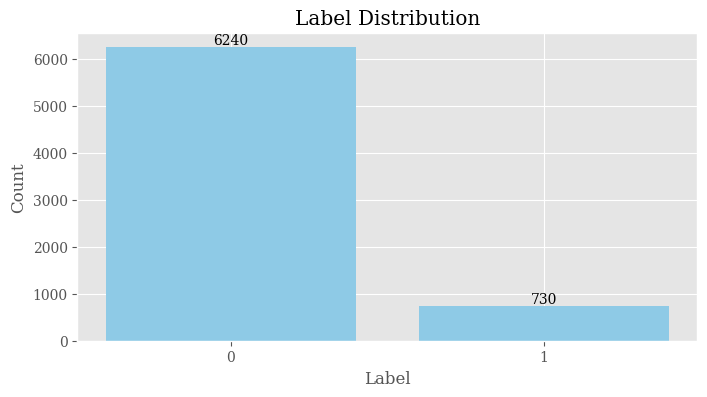

In [4]:
# Pre-processing
df = df.dropna()
df = df.reset_index(drop=True)
# df['label'] = df['label'].astype('float64')
df.info()

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(8, 4), dpi=100)

label_counts = df['label'].value_counts()
plt.bar(label_counts.index, label_counts.values, color='#8ecae6')
for i, value in enumerate(label_counts.values):
    plt.text(i, value, str(value), ha='center', va='bottom', fontsize=10)
plt.xticks(label_counts.index)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

We can see that this dataset is imbalanced. To reduce overfitting in the model, I conducted an augmentation process using Contextual Word Embeddings which generates more data from the initial dataset

In [5]:
def augmentMyData(df, augmenter, repetitions=1, samples=200, random_seed=42):
    np.random.seed(random_seed)
    augmented_texts = []

    depressed_df = df[df['label'] == 1.0].reset_index(drop=True)
    random_indices = np.random.randint(0, len(depressed_df), size=samples)

    for i in tqdm(random_indices, desc="Augmenting Data"):
        for _ in range(repetitions):
            augmented_text = augmenter.augment(depressed_df['text'].iloc[i])

            if isinstance(augmented_text, list):
                augmented_text = ' '.join(augmented_text)
            augmented_texts.append(augmented_text)

    aug_df = pd.DataFrame({
        'label': [1.0] * len(augmented_texts),
        'text': augmented_texts
    })

    df = pd.concat([df, aug_df], ignore_index=True)
    df = shuffle(df, random_state=random_seed).reset_index(drop=True)

    return aug_df, df

augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert") #substitute
aug_df, df = augmentMyData(df, augmenter, repetitions=1, samples=2190)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Augmenting Data: 100%|██████████| 2190/2190 [12:38<00:00,  2.89it/s]


In [6]:
label_counts = df['label'].value_counts()
print(label_counts)

label
0.0    6240
1.0    2920
Name: count, dtype: int64


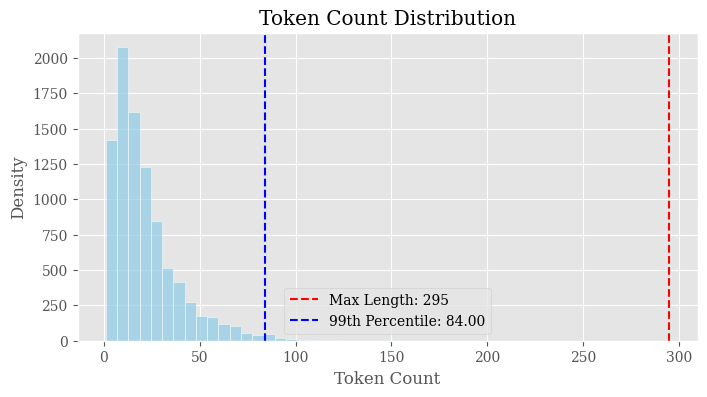

In [7]:
# Tokenize texts and visualize token count distribution
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
df["text_length"] = df["text"].apply(lambda x: len(tokenizer.tokenize(str(x))))
p99 = np.percentile(df["text_length"], 99)

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(8,4), dpi=100)

plt.hist(df["text_length"], bins=50, color='#8ecae6', alpha=0.7, edgecolor="white")
plt.axvline(df["text_length"].max(), color="red", linestyle="dashed", label=f"Max Length: {df['text_length'].max()}")
plt.axvline(p99, color="blue", linestyle="dashed", label=f"99th Percentile: {p99:.2f}")

plt.xlabel("Token Count")
plt.ylabel("Density")
plt.title("Token Count Distribution")
plt.legend()
plt.show()

df_encodings = tokenizer(list(df['text']), truncation=True, padding=True, max_length=512)

<a name='2'></a>
### 2 - Build BERT model using Transfer learning

In [8]:
# Create dataset class
class DepressionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512): #256 512
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize sentences and create input tensor
        encoding = self.tokenizer(text,
                                  truncation=True,
                                  padding="max_length",
                                  max_length=self.max_len,
                                  return_tensors="pt")

        # Return a dictionary with tensors
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.float)
        }

In [9]:
# Split dataset to train, validation and test set
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    test_texts,
    test_labels,
    test_size=0.5,
    random_state=42
)

train_dataset = DepressionDataset(train_texts, train_labels, tokenizer, max_len=512)
val_dataset = DepressionDataset(val_texts, val_labels, tokenizer, max_len=512)
test_dataset = DepressionDataset(test_texts, test_labels, tokenizer, max_len=512)

print(f"Train size: {len(train_texts)}")
print(f"Validation size: {len(val_texts)}")
print(f"Test size: {len(test_texts)}")

Train size: 7328
Validation size: 916
Test size: 916


In [ ]:
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# for batch in train_dataloader:
#     print(batch)
#     break

In [10]:
labels = [int(sample["label"].item()) for sample in train_dataset]
class_counts = np.bincount(labels)
class_weights = 1.0 / (class_counts + 1e-6)
sample_weights = [class_weights[label] for label in labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
class DepressionBERT(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased"):
        super(DepressionBERT, self).__init__()
        # Load pre-trained BERT model and Freeze all parameters of BERT
        self.bert = BertModel.from_pretrained(bert_model_name)
        for param in self.bert.parameters():
            param.requires_grad = False

        # Add 2 fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
            )

    def forward(self, input_ids, attention_mask):
        # Get hidden states from BERT base model and output from token [CLS] (representation for all of sentences)
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        # Run fully connected layers with ReLU activation, Dropout, and Sigmoid function
        x = self.fc(pooled_output)

        return x
DepressionBERT()

DepressionBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

<a name='3'></a>
### 3 - Train model

In [17]:
def train_model(train_dataloader, val_dataloader, epochs=2):
    model = DepressionBERT()
    weights_path = './weights_bert.pth'
    if os.path.exists(weights_path):
      model.load_state_dict(torch.load(weights_path))
      print("Found file 'weights_bert.pth', loaded weights successfully!")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=0.0001, correct_bias=False)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    loss_fn = nn.BCELoss()

    best_acc = 0.0
    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        train_total = 0
        train_correct = 0

        for batch in train_dataloader:
            # Prepare data from batch
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            # Conduct forward pass
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs.squeeze(), labels)
            train_loss += loss.item()
            # Calculate accuracy
            preds = (outputs.squeeze() > 0.5).float()  # Use threshold 0.5 for binary classification
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
            # Conduct backward pass and update weights
            loss.backward()
            optimizer.step()
        train_acc = train_correct / train_total
        train_loss /= len(train_dataloader)
        scheduler.step()

        # Validate
        model.eval()
        val_loss = 0
        val_total = 0
        val_correct = 0

        with torch.no_grad():
            for batch in val_dataloader:
                # Prepare data from batch
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)
                # Conduct forward pass
                outputs = model(input_ids, attention_mask)
                preds = (outputs.squeeze() > 0.5).float()
                loss = loss_fn(outputs.squeeze(), labels)
                val_loss += loss.item()
                # Calculate accuracy
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_loss /= len(val_dataloader)
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}")

        # Save the best model
        if val_acc > best_acc:
          best_acc = val_acc
          torch.save(model.state_dict(), weights_path)
          print('Best model saved')

train_model(train_dataloader, val_dataloader, epochs=15)

Found file 'weights_bert.pth', loaded weights successfully!


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15: Train Loss: 0.3243 | Train Acc: 0.87 | Val Loss: 0.3135 | Val Acc: 0.88
Best model saved
Epoch 2/15: Train Loss: 0.3085 | Train Acc: 0.87 | Val Loss: 0.2762 | Val Acc: 0.89
Best model saved
Epoch 3/15: Train Loss: 0.3080 | Train Acc: 0.87 | Val Loss: 0.2849 | Val Acc: 0.88
Epoch 4/15: Train Loss: 0.3110 | Train Acc: 0.87 | Val Loss: 0.3055 | Val Acc: 0.87
Epoch 5/15: Train Loss: 0.3135 | Train Acc: 0.87 | Val Loss: 0.2697 | Val Acc: 0.88
Epoch 6/15: Train Loss: 0.3100 | Train Acc: 0.87 | Val Loss: 0.2685 | Val Acc: 0.89
Best model saved
Epoch 7/15: Train Loss: 0.3049 | Train Acc: 0.88 | Val Loss: 0.2621 | Val Acc: 0.90
Best model saved
Epoch 8/15: Train Loss: 0.3009 | Train Acc: 0.88 | Val Loss: 0.2673 | Val Acc: 0.89
Epoch 9/15: Train Loss: 0.2981 | Train Acc: 0.88 | Val Loss: 0.2567 | Val Acc: 0.90
Best model saved
Epoch 10/15: Train Loss: 0.2924 | Train Acc: 0.88 | Val Loss: 0.2708 | Val Acc: 0.89
Epoch 11/15: Train Loss: 0.3055 | Train Acc: 0.87 | Val Loss: 0.2675 | Val

<a name='4'></a>
### 4 - Evaluation and Visualization of the results

Found file 'weights_bert.pth', loaded weights successfully!
               precision    recall  f1-score   support

Non-Depressed       0.92      0.94      0.93       613
    Depressed       0.87      0.83      0.85       303

     accuracy                           0.90       916
    macro avg       0.89      0.88      0.89       916
 weighted avg       0.90      0.90      0.90       916



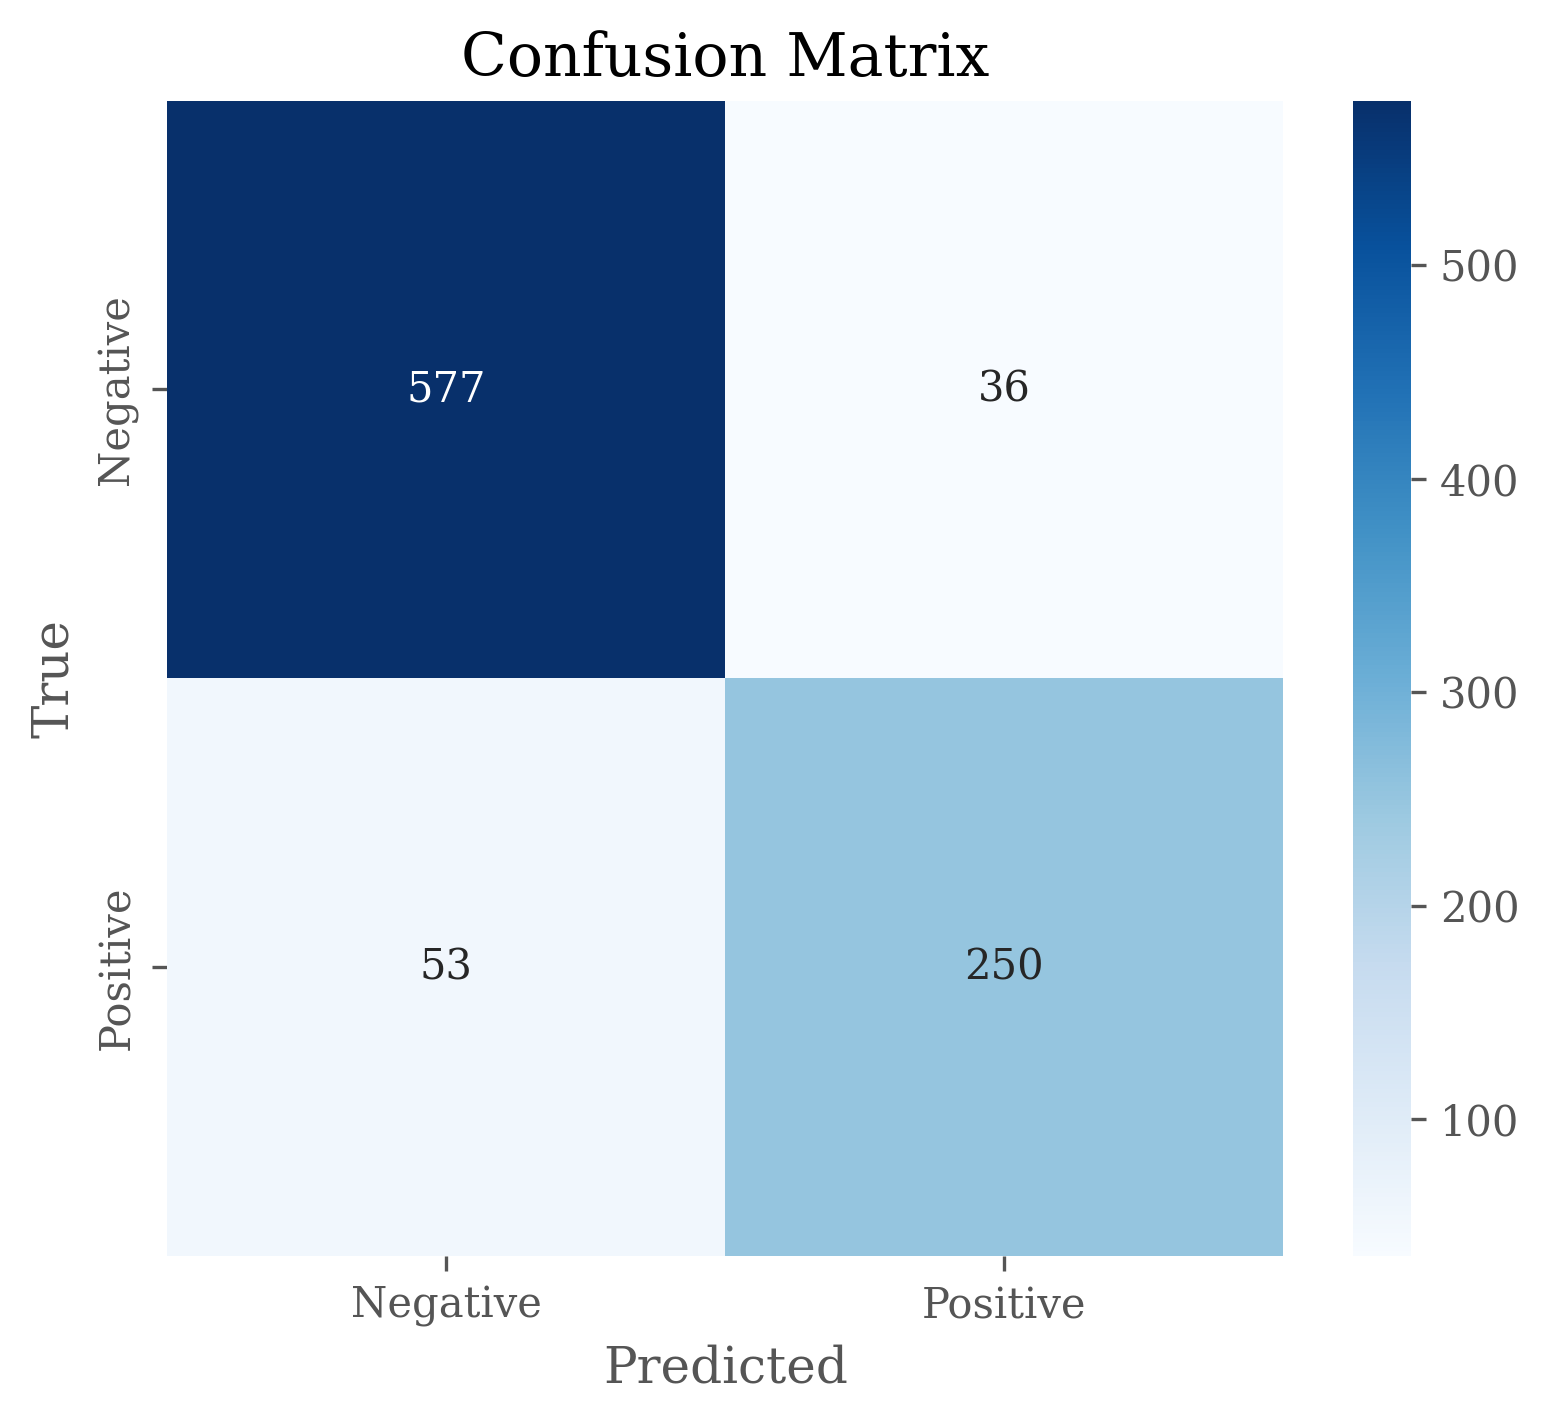

In [18]:
def evaluate_model(test_dataloader):
    model = DepressionBERT()
    weights_path = './weights_bert.pth'
    if os.path.exists(weights_path):
      model.load_state_dict(torch.load(weights_path))
      print("Found file 'weights_bert.pth', loaded weights successfully!")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loss_fn = nn.BCELoss()

    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            preds = (outputs.squeeze() > 0.5).float()

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=['Non-Depressed', 'Depressed'])
    print(report)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5), dpi=300)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(test_dataloader)